In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().resolve().parent))

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from nudca import load_decay_database
from nudca import load_decay_matrix
from nudca import RadioactiveDecay
from nudca.io import Inputer, AbundanceEstimator

from nudca.kilonovae import KNeLightCurve

beta = np.loadtxt(Path.cwd().resolve().parent.joinpath('plots/data/Hotokezaka/heat_beta.dat'), comments='#', unpack=True)
alpha = np.loadtxt(Path.cwd().resolve().parent.joinpath('plots/data/Hotokezaka/heat_alpha.dat'), comments='#', unpack=True)
fission = np.loadtxt(Path.cwd().resolve().parent.joinpath('plots/data/Hotokezaka/heat_fission.dat'), comments='#', unpack=True)

t_hotokezaka = beta[0]
q_hotokezaka = beta[1] + alpha[1] + fission[1]

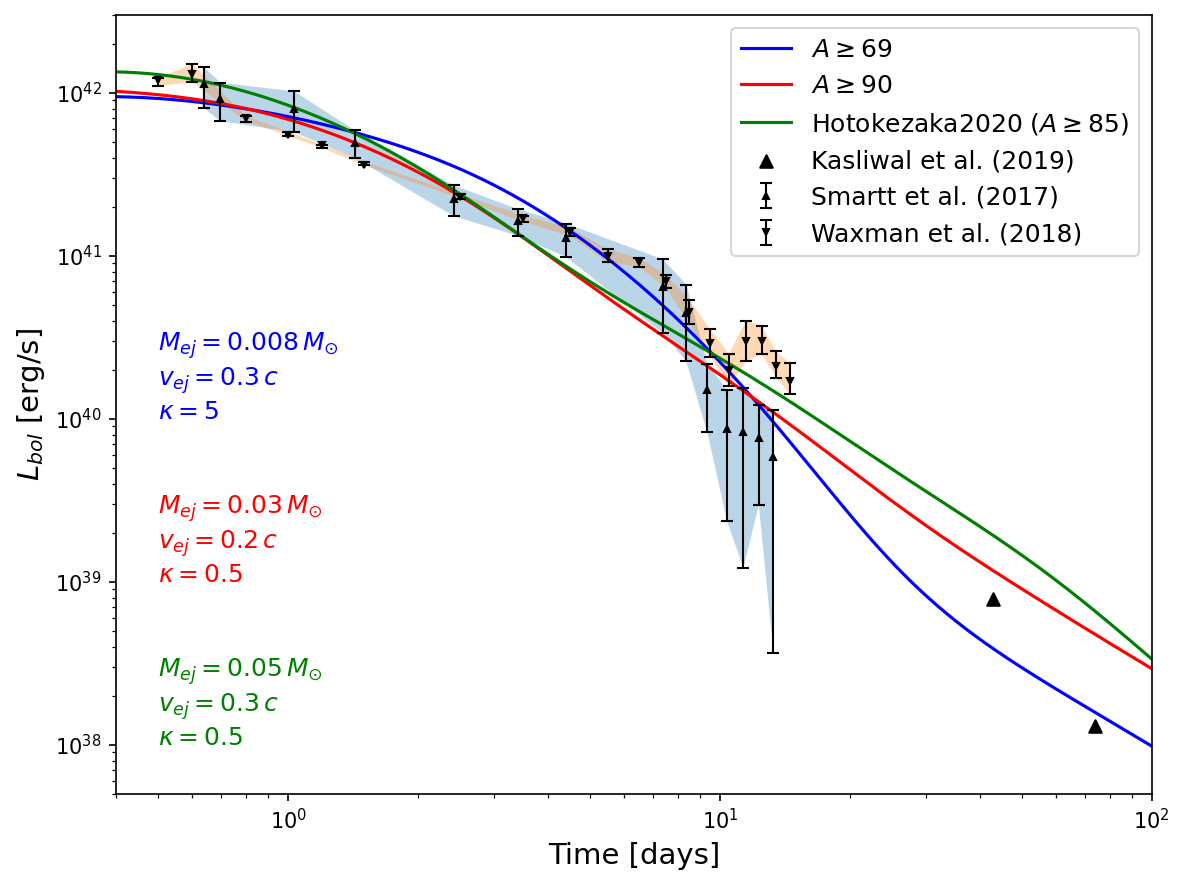

In [ ]:

decay_database = load_decay_database(data_source='ENDF-B-VIII.1_decay')
decay_matrix = load_decay_matrix(data_source='ENDF-B-VIII.1_decay')


Y_ini_A69 = pd.read_excel(Path.cwd().resolve().parent.joinpath('plots/data/AbundanceY/solar_Yini_A69.xlsx'), index_col=0).to_dict()['Y']
Y_ini_A90 = pd.read_excel(Path.cwd().resolve().parent.joinpath('plots/data/AbundanceY/solar_Yini_A90.xlsx'), index_col=0).to_dict()['Y']
radioactive_decay_A69 = RadioactiveDecay(Y_ini_A69, decay_database, decay_matrix)
radioactive_decay_A90 = RadioactiveDecay(Y_ini_A90, decay_database, decay_matrix)

decay_times = np.geomspace(1.e-2, 1.e2, 10000) * 86400
q_A69 = radioactive_decay_A69.total_decay_heating_rates(decay_times)
q_A90 = radioactive_decay_A90.total_decay_heating_rates(decay_times)


df_smartt = pd.read_excel(Path.cwd().resolve().parent.joinpath('plots/data/AT2017gfo/Lbol_Smartt2017.xlsx'))
df_waxman = pd.read_excel(Path.cwd().resolve().parent.joinpath('plots/data/AT2017gfo/Lbol_Waxman2018.xlsx'))
df_kasliwal = pd.read_excel(Path.cwd().resolve().parent.joinpath('plots/data/AT2017gfo/Lbol_Kasliwal2019.xlsx'))

t_smartt = df_smartt['Time'].values
log_Lbol_smartt = df_smartt['log_Lbol'].values
log_err_smartt = df_smartt['log_Err'].values
Lbol_smartt = 10**log_Lbol_smartt
err_smartt = Lbol_smartt * np.log(10) * log_err_smartt

t_waxman = df_waxman['Time'].values
Lbol_waxman = df_waxman['Lbol'].values
err_lower_waxman = df_waxman['Lower'].values
err_upper_waxman = df_waxman['Upper'].values
err_waxman = [err_lower_waxman, err_upper_waxman]

t_kasliwal = df_kasliwal['Time'].values
Lbol_kasliwal = df_kasliwal['Lbol'].values

t_A69, Lbol_A69 = KNeLightCurve(
        lightcurve_type = 'Luminosity',       # ['Luminosity', 'Magnitude']
        velocity_scheme= 'Default',           # Uniform distribution
        density_scheme= 'Metzger2017',        # ['Metzger2017', 'Kasen2017', 'Wollaeger2018']
        thermal_scheme= 'Barnes2016_Default', # ['Barnes2016_Default', 'Barnes2016_1D', 'Barnes2016_2D']
        heating_scheme= 'Table',       # ['Korobkin2012', 'Rosswog2024', 'Table']
        heating_rate_data = (decay_times, q_A69),
        mass_ejecta = 0.008,  # units: M_sun
        vel_ejecta = 0.3,    # units: c
        opacity = 5,                       # ['Wu2022', 'Ekanger2023', 'Tanaka_OneVar', 'Tanaka_FourVar']
)(times=decay_times)

t_A90, Lbol_A90 = KNeLightCurve(
        lightcurve_type = 'Luminosity',       # ['Luminosity', 'Magnitude']
        velocity_scheme= 'Default',           # Uniform distribution
        density_scheme= 'Metzger2017',        # ['Metzger2017', 'Kasen2017', 'Wollaeger2018']
        thermal_scheme= 'Barnes2016_Default', # ['Barnes2016_Default', 'Barnes2016_1D', 'Barnes2016_2D']
        heating_scheme= 'Table',              # ['Korobkin2012', 'Rosswog2024', 'Table']
        heating_rate_data = (decay_times, q_A90),
        mass_ejecta = 0.03,  # units: M_sun
        vel_ejecta = 0.2,    # units: c
        opacity = 0.5,                       # ['Wu2022', 'Ekanger2023', 'Tanaka_OneVar', 'Tanaka_FourVar']
)(times=decay_times)

t_A85, Lbol_A85 = KNeLightCurve(
        lightcurve_type = 'Luminosity',       # ['Luminosity', 'Magnitude']
        velocity_scheme= 'Default',           # Uniform distribution
        density_scheme= 'Metzger2017',        # ['Metzger2017', 'Kasen2017', 'Wollaeger2018']
        thermal_scheme= 'Barnes2016_Default', # ['Barnes2016_Default', 'Barnes2016_1D', 'Barnes2016_2D']
        heating_scheme= 'Table',              # ['Korobkin2012', 'Rosswog2024', 'Table']
        heating_rate_data = (t_hotokezaka*86400, q_hotokezaka),
        mass_ejecta = 0.03,  # units: M_sun
        vel_ejecta = 0.2,    # units: c
        opacity = 0.5,                       # ['Wu2022', 'Ekanger2023', 'Tanaka_OneVar', 'Tanaka_FourVar']
)(times=decay_times)


# t_hotokezaka, Lbol_hotokezaka = np.loadtxt(Path.cwd().resolve().parent.joinpath('plots/data/Hotokezaka/lightcurve.dat'), unpack=True, usecols=(0, 1))

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

ax.plot(t_A69/86400, Lbol_A69, color='blue', label=r'$A \geq 69$')
ax.plot(t_A90/86400, Lbol_A90, color='red', label=r'$A \geq 90$')
ax.plot(t_A85/86400, Lbol_A85, color='green', label=r'Hotokezaka2020 ($A \geq 85$)')
ax.errorbar(t_smartt, Lbol_smartt, yerr=err_smartt,
            fmt='^', color='black', ecolor='black', 
            markersize=3, capsize=3, elinewidth=1, 
            capthick=1, label='Smartt et al. (2017)')  
ax.errorbar(t_waxman, Lbol_waxman, yerr=err_waxman,
            fmt='v', color='black', ecolor='black',
            markersize=3, capsize=3, elinewidth=1,
            capthick=1, label='Waxman et al. (2018)')  
ax.scatter(t_kasliwal, Lbol_kasliwal, color='black', marker='^', label='Kasliwal et al. (2019)')

ax.fill_between(t_smartt, Lbol_smartt - err_smartt, Lbol_smartt + err_smartt, alpha=0.3)
ax.fill_between(t_waxman, Lbol_waxman - err_waxman[0], Lbol_waxman + err_waxman[1], alpha=0.3)

ax.set_xlim(4e-1, 1.e2)
ax.set_ylim(5e37, 3e42)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel(r'$L_{bol}$ [erg/s]', fontsize=14)

ax.text(
    0.5, 1e40,
    r'$M_{ej} = 0.008\, M_{\odot}$' + '\n' +
    r'$v_{ej} = 0.3\, c$' + '\n' +
    r'$\kappa = 5$',
    fontsize=12,
    color='blue'
)
ax.text(
    0.5, 1e39,
    r'$M_{ej} = 0.03\, M_{\odot}$' + '\n' +
    r'$v_{ej} = 0.2\, c$' + '\n' +
    r'$\kappa = 0.5$',
    fontsize=12,
    color='red'
)
ax.text(
    0.5, 1e38,
    r'$M_{ej} = 0.05\, M_{\odot}$' + '\n' +
    r'$v_{ej} = 0.3\, c$' + '\n' +
    r'$\kappa = 0.5$',
    fontsize=12,
    color='green'
)

ax.legend(fontsize=12)
plt.tight_layout()
# plt.show()

fig.savefig(Path.cwd().resolve().parent.joinpath('plots/figures/AT2017gfo.png'), dpi=300)
